# FomulaBEAT

変更点
- 低次元で学習させる
- QKVについてもっと詳しく分析する


In [55]:
version = '02-1'
model_dir = './model/' + version
data_path = 'data/eq02.txt'

In [56]:
from pathlib import Path
import math
import time
from collections import Counter
from tqdm import tqdm
import torch
from torch.utils.data import random_split
import torch.nn as nn
from torch import Tensor
from torch.nn import (
    TransformerEncoder, TransformerDecoder,
    TransformerEncoderLayer, TransformerDecoderLayer
)
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import vocab
from torchtext.utils import download_from_url, extract_archive

パラメータの事前設定

In [57]:
%load_ext autoreload
%autoreload 2
torch.set_printoptions(linewidth=100)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model_dir_path = Path(model_dir)
if not model_dir_path.exists():
    model_dir_path.mkdir(parents=True)

データの取得

In [59]:
def read_equation_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    src_data, tgt_data = [], []
    for line in lines:
        src, tgt = line.strip().split('=')
        src_data.append(src)
        tgt_data.append(tgt)
    return src_data, tgt_data


In [60]:
# ファイルを読み込み、数式データを取得
src_data, tgt_data = read_equation_file(data_path)
print(src_data[:3], tgt_data[:3])


['8+0', '5+2', '5+1'] ['8', '7', '6']


辞書データの作成

In [61]:

SPECIALS = ['<unk>', '<pad>', '<start>', '<end>']

def build_vocab(texts):
    vocab = {}
    idx = 0
    # 数字の語彙定義
    for i in range(10):
        vocab[str(i)] = idx
        idx += 1
    # 特別語の語彙定義
    for sp in SPECIALS:
        vocab[sp] = idx
        idx += 1
    # その他の文字の語彙定義
    for text in texts:
        for char in text:
            if char not in vocab:
                vocab[char] = idx
                idx += 1
    return vocab


def convert_text_to_indexes(text, vocab):
    # <start> と <end> トークンを追加して数値化
    return [vocab['<start>']] + [vocab[char] if char in vocab else vocab['<unk>'] for char in text] + [vocab['<end>']]

# データを処理して Train と Valid に分ける関数
# データを処理して Train と Valid に分ける関数
def data_process_split(src_texts, tgt_texts, vocab_src, vocab_tgt, valid_size=0.2):
    # データを数値化
    data = []
    for (src, tgt) in zip(src_texts, tgt_texts):
        src_tensor = torch.tensor(convert_text_to_indexes(src, vocab_src), dtype=torch.long)
        tgt_tensor = torch.tensor(convert_text_to_indexes(tgt, vocab_tgt), dtype=torch.long)
        data.append((src_tensor, tgt_tensor))
    
    # データのサイズを計算して、訓練データと検証データに分割
    data_size = len(data)
    valid_size = int(valid_size * data_size)
    train_size = data_size - valid_size

    # PyTorchのrandom_splitを使って分割
    train_data, valid_data = random_split(data, [train_size, valid_size])
    
    return train_data, valid_data



In [62]:
# 辞書と逆辞書を構築
vocab_src = build_vocab(src_data)
vocab_tgt = build_vocab(tgt_data)

print(vocab_tgt)

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '<unk>': 10, '<pad>': 11, '<start>': 12, '<end>': 13}


In [63]:

# データを数値化
train_data, valid_data = data_process_split(src_data, tgt_data, vocab_src, vocab_tgt)

# 結果の確認
print('インデックス化された文章')
print(f"Input: {train_data[0][0]}\nOutput: {train_data[0][1]}")

# インデックスから元の文字列に戻す
def convert_indexes_to_text(indexes, vocab):
    reverse_vocab = {idx: token for token, idx in vocab.items()}
    indexes = indexes.tolist()
    return ''.join([reverse_vocab[idx] for idx in indexes if idx in reverse_vocab and reverse_vocab[idx] not in ['<start>', '<end>', '<pad>']])

print('元に戻した文章')
print(f"Input: {convert_indexes_to_text(train_data[0][0], vocab_src)}")
print(f"Output: {convert_indexes_to_text(train_data[0][1], vocab_tgt)}")


インデックス化された文章
Input: tensor([12,  8, 14,  8, 13])
Output: tensor([12,  1,  6, 13])
元に戻した文章
Input: 8+8
Output: 16


In [64]:
batch_size = 128
PAD_IDX = vocab_src['<pad>']
START_IDX = vocab_src['<start>']
END_IDX = vocab_src['<end>']

def generate_batch(data_batch):
    
    batch_src, batch_tgt = [], []
    for src, tgt in data_batch:
        batch_src.append(src)
        batch_tgt.append(tgt)
        
    batch_src = pad_sequence(batch_src, padding_value=PAD_IDX)
    batch_tgt = pad_sequence(batch_tgt, padding_value=PAD_IDX)
    
    return batch_src, batch_tgt

train_iter = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=generate_batch)
valid_iter = DataLoader(valid_data, batch_size=batch_size, shuffle=True, collate_fn=generate_batch)

In [65]:
len(train_data)

8000

Transoformerの設定

In [66]:
class TokenEmbedding(nn.Module):
    
    def __init__(self, vocab_size, embedding_size):
        
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.embedding_size = embedding_size
        
    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.embedding_size)
    
    
class PositionalEncoding(nn.Module):
    
    def __init__(self, embedding_size: int, dropout: float, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        
        den = torch.exp(-torch.arange(0, embedding_size, 2) * math.log(10000) / embedding_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        embedding_pos = torch.zeros((maxlen, embedding_size))
        embedding_pos[:, 0::2] = torch.sin(pos * den)
        embedding_pos[:, 1::2] = torch.cos(pos * den)
        embedding_pos = embedding_pos.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('embedding_pos', embedding_pos)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.embedding_pos[: token_embedding.size(0), :])


In [72]:

class Seq2SeqTransformer(nn.Module):
    
    def __init__(
        self, num_encoder_layers: int, num_decoder_layers: int,
        embedding_size: int, vocab_size_src: int, vocab_size_tgt: int,
        dim_feedforward:int = 512, dropout:float = 0.1, nhead:int = 8
    ):
        
        super(Seq2SeqTransformer, self).__init__()

        self.token_embedding_src = TokenEmbedding(vocab_size_src, embedding_size)
        self.positional_encoding = PositionalEncoding(embedding_size, dropout=dropout)
        encoder_layer = TransformerEncoderLayer(
            d_model=embedding_size, nhead=nhead, dim_feedforward=dim_feedforward
        )
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        
        self.token_embedding_tgt = TokenEmbedding(vocab_size_tgt, embedding_size)
        decoder_layer = TransformerDecoderLayer(
            d_model=embedding_size, nhead=nhead, dim_feedforward=dim_feedforward
        )
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)
        
        self.output = nn.Linear(embedding_size, vocab_size_tgt)

    def forward(
        self, src: Tensor, tgt: Tensor,
        mask_src: Tensor, mask_tgt: Tensor,
        padding_mask_src: Tensor, padding_mask_tgt: Tensor,
        memory_key_padding_mask: Tensor
    ):
        
        embedding_src = self.positional_encoding(self.token_embedding_src(src))
        memory = self.transformer_encoder(embedding_src, mask_src, padding_mask_src)
        embedding_tgt = self.positional_encoding(self.token_embedding_tgt(tgt))
        outs = self.transformer_decoder(
            embedding_tgt, memory, mask_tgt, None,
            padding_mask_tgt, memory_key_padding_mask
        )
        return self.output(outs)

    def encode(self, src: Tensor, mask_src: Tensor):
        return self.transformer_encoder(self.positional_encoding(self.token_embedding_src(src)), mask_src)

    def decode(self, tgt: Tensor, memory: Tensor, mask_tgt: Tensor):
        return self.transformer_decoder(self.positional_encoding(self.token_embedding_tgt(tgt)), memory, mask_tgt)

In [73]:
def create_mask(src, tgt, PAD_IDX):
    
    seq_len_src = src.shape[0]
    seq_len_tgt = tgt.shape[0]

    mask_src = torch.zeros((seq_len_src, seq_len_src), device=device).type(torch.bool)
    mask_tgt = generate_square_subsequent_mask(seq_len_tgt)

    padding_mask_src = (src == PAD_IDX).transpose(0, 1)
    padding_mask_tgt = (tgt == PAD_IDX).transpose(0, 1)
    
    return mask_src, mask_tgt, padding_mask_src, padding_mask_tgt


def generate_square_subsequent_mask(seq_len):
    mask = (torch.triu(torch.ones((seq_len, seq_len), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

学習の定義

In [81]:
def train(model, data, optimizer, criterion, PAD_IDX):
    
    model.train()
    losses = 0
    for src, tgt in tqdm(data):
        
        src = src.to(device)
        tgt = tgt.to(device)

        input_tgt = tgt[:-1, :]

        mask_src, mask_tgt, padding_mask_src, padding_mask_tgt = create_mask(src, input_tgt, PAD_IDX)

        logits = model(
            src=src, tgt=input_tgt,
            mask_src=mask_src, mask_tgt=mask_tgt,
            padding_mask_src=padding_mask_src, padding_mask_tgt=padding_mask_tgt,
            memory_key_padding_mask=padding_mask_src
        )

        optimizer.zero_grad()
        output_tgt = tgt[1:, :]
        loss = criterion(logits.reshape(-1, logits.shape[-1]), output_tgt.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()
        
    return losses / len(data)

In [82]:

def evaluate(model, data, criterion, PAD_IDX):
    
    model.eval()
    losses = 0
    for src, tgt in data:
        
        src = src.to(device)
        tgt = tgt.to(device)

        input_tgt = tgt[:-1, :]

        mask_src, mask_tgt, padding_mask_src, padding_mask_tgt = create_mask(src, input_tgt, PAD_IDX)

        logits = model(
            src=src, tgt=input_tgt,
            mask_src=mask_src, mask_tgt=mask_tgt,
            padding_mask_src=padding_mask_src, padding_mask_tgt=padding_mask_tgt,
            memory_key_padding_mask=padding_mask_src
        )
        
        output_tgt = tgt[1:, :]
        loss = criterion(logits.reshape(-1, logits.shape[-1]), output_tgt.reshape(-1))
        losses += loss.item()
        
    return losses / len(data)

設定

In [87]:
vocab_size_src = len(vocab_src)
vocab_size_tgt = len(vocab_tgt)
embedding_size = 240
nhead = 1
dim_feedforward = 100
num_encoder_layers = 1
num_decoder_layers = 1
dropout = 0.1
# vocab_size_src = len(vocab_src)
# vocab_size_tgt = len(vocab_tgt)
# embedding_size = 240
# nhead = 8
# dim_feedforward = 100
# num_encoder_layers = 2
# num_decoder_layers = 2
# dropout = 0.1

model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    embedding_size=embedding_size,
    vocab_size_src=vocab_size_src, vocab_size_tgt=vocab_size_tgt,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(device)

criterion = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(model.parameters())

モデルの調査

In [88]:
print(model)

Seq2SeqTransformer(
  (token_embedding_src): TokenEmbedding(
    (embedding): Embedding(15, 240)
  )
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=240, out_features=240, bias=True)
        )
        (linear1): Linear(in_features=240, out_features=100, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=100, out_features=240, bias=True)
        (norm1): LayerNorm((240,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((240,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (token_embedding_tgt): TokenEmbedding(
    (embedding): Embedding(14, 240)
  )
  (transforme

In [89]:
# モデル内の層の名前とパラメータ情報を表示
LP = list(model.named_parameters())
lp = len(LP)
print(f"{lp} 層")
for p in range(0, lp):
    print(f"\n層名: {LP[p][0]}")
    print(f"形状: {LP[p][1].shape}")
    print(f"値: {LP[p][1]}")


34 層

層名: token_embedding_src.embedding.weight
形状: torch.Size([15, 240])
値: Parameter containing:
tensor([[-0.0323, -0.1331, -0.0720,  ...,  0.0797,  0.1043, -0.0054],
        [-0.0264, -0.0659, -0.1458,  ..., -0.0322,  0.0692,  0.1226],
        [-0.0277,  0.1229, -0.0458,  ...,  0.0466, -0.0598, -0.0829],
        ...,
        [-0.0358,  0.0509,  0.0963,  ...,  0.0973,  0.0310,  0.0009],
        [ 0.0792, -0.0491,  0.0017,  ..., -0.1331, -0.0692, -0.0079],
        [-0.0222, -0.0826, -0.1375,  ...,  0.0031, -0.0396, -0.1128]], device='cuda:0',
       requires_grad=True)

層名: transformer_encoder.layers.0.self_attn.in_proj_weight
形状: torch.Size([720, 240])
値: Parameter containing:
tensor([[ 0.0219, -0.0351, -0.0290,  ..., -0.0306,  0.0496, -0.0374],
        [-0.0270, -0.0483, -0.0774,  ...,  0.0157,  0.0318, -0.0301],
        [-0.0409, -0.0670,  0.0210,  ..., -0.0069,  0.0161,  0.0564],
        ...,
        [-0.0744,  0.0371, -0.0458,  ...,  0.0310,  0.0487, -0.0509],
        [-0.0603, -0

## 学習実行

In [90]:
epoch = 100
best_loss = float('Inf')
best_model = None
patience = 10
counter = 0

for loop in range(1, epoch + 1):
    
    start_time = time.time()
    
    loss_train = train(
        model=model, data=train_iter, optimizer=optimizer,
        criterion=criterion, PAD_IDX=PAD_IDX
    )
    
    elapsed_time = time.time() - start_time
    
    loss_valid = evaluate(
        model=model, data=valid_iter, criterion=criterion, PAD_IDX=PAD_IDX
    )
    
    print('[{}/{}] train loss: {:.2f}, valid loss: {:.2f}  [{}{:.0f}s] counter: {} {}'.format(
        loop, epoch,
        loss_train, loss_valid,
        str(int(math.floor(elapsed_time / 60))) + 'm' if math.floor(elapsed_time / 60) > 0 else '',
        elapsed_time % 60,
        counter,
        '**' if best_loss > loss_valid else ''
    ))
    
    if best_loss > loss_valid:
        best_loss = loss_valid
        best_model = model
        counter = 0
        
    if counter > patience:
        break
    
    counter += 1

  0%|          | 0/63 [00:00<?, ?it/s]

/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
100%|██████████| 63/63 [00:01<00:00, 49.31it/s]


[1/100] train loss: 1.17, valid loss: 0.57  [1s] counter: 0 **


100%|██████████| 63/63 [00:01<00:00, 52.54it/s]


[2/100] train loss: 0.60, valid loss: 0.31  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 51.15it/s]


[3/100] train loss: 0.45, valid loss: 0.19  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 50.67it/s]


[4/100] train loss: 0.37, valid loss: 0.19  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 52.71it/s]


[5/100] train loss: 0.35, valid loss: 0.15  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 52.76it/s]


[6/100] train loss: 0.30, valid loss: 0.14  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 51.75it/s]


[7/100] train loss: 0.27, valid loss: 0.12  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 52.21it/s]


[8/100] train loss: 0.26, valid loss: 0.11  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 52.06it/s]


[9/100] train loss: 0.26, valid loss: 0.11  [1s] counter: 1 


100%|██████████| 63/63 [00:01<00:00, 51.51it/s]


[10/100] train loss: 0.23, valid loss: 0.07  [1s] counter: 2 **


100%|██████████| 63/63 [00:01<00:00, 52.19it/s]


[11/100] train loss: 0.19, valid loss: 0.04  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 52.55it/s]


[12/100] train loss: 0.18, valid loss: 0.04  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 52.12it/s]


[13/100] train loss: 0.15, valid loss: 0.02  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 52.24it/s]


[14/100] train loss: 0.15, valid loss: 0.01  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 52.29it/s]


[15/100] train loss: 0.14, valid loss: 0.02  [1s] counter: 1 


100%|██████████| 63/63 [00:01<00:00, 51.63it/s]


[16/100] train loss: 0.12, valid loss: 0.00  [1s] counter: 2 **


100%|██████████| 63/63 [00:01<00:00, 51.37it/s]


[17/100] train loss: 0.12, valid loss: 0.01  [1s] counter: 1 


100%|██████████| 63/63 [00:01<00:00, 51.05it/s]


[18/100] train loss: 0.10, valid loss: 0.00  [1s] counter: 2 **


100%|██████████| 63/63 [00:01<00:00, 52.13it/s]


[19/100] train loss: 0.12, valid loss: 0.00  [1s] counter: 1 


100%|██████████| 63/63 [00:01<00:00, 52.08it/s]


[20/100] train loss: 0.11, valid loss: 0.05  [1s] counter: 2 


100%|██████████| 63/63 [00:01<00:00, 53.08it/s]


[21/100] train loss: 0.11, valid loss: 0.01  [1s] counter: 3 


100%|██████████| 63/63 [00:01<00:00, 52.85it/s]


[22/100] train loss: 0.09, valid loss: 0.01  [1s] counter: 4 


100%|██████████| 63/63 [00:01<00:00, 52.82it/s]


[23/100] train loss: 0.09, valid loss: 0.00  [1s] counter: 5 **


100%|██████████| 63/63 [00:01<00:00, 51.66it/s]


[24/100] train loss: 0.09, valid loss: 0.02  [1s] counter: 1 


100%|██████████| 63/63 [00:01<00:00, 52.53it/s]


[25/100] train loss: 0.09, valid loss: 0.00  [1s] counter: 2 


100%|██████████| 63/63 [00:01<00:00, 52.64it/s]


[26/100] train loss: 0.08, valid loss: 0.00  [1s] counter: 3 **


100%|██████████| 63/63 [00:01<00:00, 51.98it/s]


[27/100] train loss: 0.08, valid loss: 0.00  [1s] counter: 1 


100%|██████████| 63/63 [00:01<00:00, 51.10it/s]


[28/100] train loss: 0.08, valid loss: 0.00  [1s] counter: 2 


100%|██████████| 63/63 [00:01<00:00, 51.10it/s]


[29/100] train loss: 0.08, valid loss: 0.00  [1s] counter: 3 **


100%|██████████| 63/63 [00:01<00:00, 52.99it/s]


[30/100] train loss: 0.08, valid loss: 0.00  [1s] counter: 1 


100%|██████████| 63/63 [00:01<00:00, 52.05it/s]


[31/100] train loss: 0.07, valid loss: 0.00  [1s] counter: 2 


100%|██████████| 63/63 [00:01<00:00, 52.53it/s]


[32/100] train loss: 0.07, valid loss: 0.00  [1s] counter: 3 


100%|██████████| 63/63 [00:01<00:00, 51.31it/s]


[33/100] train loss: 0.07, valid loss: 0.00  [1s] counter: 4 **


100%|██████████| 63/63 [00:01<00:00, 52.67it/s]


[34/100] train loss: 0.07, valid loss: 0.00  [1s] counter: 1 


100%|██████████| 63/63 [00:01<00:00, 52.63it/s]


[35/100] train loss: 0.08, valid loss: 0.00  [1s] counter: 2 


100%|██████████| 63/63 [00:01<00:00, 52.13it/s]


[36/100] train loss: 0.08, valid loss: 0.00  [1s] counter: 3 


100%|██████████| 63/63 [00:01<00:00, 53.06it/s]


[37/100] train loss: 0.08, valid loss: 0.00  [1s] counter: 4 


100%|██████████| 63/63 [00:01<00:00, 52.28it/s]


[38/100] train loss: 0.07, valid loss: 0.00  [1s] counter: 5 **


100%|██████████| 63/63 [00:01<00:00, 52.19it/s]


[39/100] train loss: 0.06, valid loss: 0.00  [1s] counter: 1 **


100%|██████████| 63/63 [00:01<00:00, 52.88it/s]


[40/100] train loss: 0.07, valid loss: 0.00  [1s] counter: 1 


100%|██████████| 63/63 [00:01<00:00, 51.25it/s]


[41/100] train loss: 0.07, valid loss: 0.00  [1s] counter: 2 


100%|██████████| 63/63 [00:01<00:00, 52.08it/s]


[42/100] train loss: 0.08, valid loss: 0.00  [1s] counter: 3 


100%|██████████| 63/63 [00:01<00:00, 52.15it/s]


[43/100] train loss: 0.08, valid loss: 0.00  [1s] counter: 4 


100%|██████████| 63/63 [00:01<00:00, 52.31it/s]


[44/100] train loss: 0.06, valid loss: 0.00  [1s] counter: 5 


100%|██████████| 63/63 [00:01<00:00, 51.25it/s]


[45/100] train loss: 0.06, valid loss: 0.00  [1s] counter: 6 


100%|██████████| 63/63 [00:01<00:00, 51.67it/s]


[46/100] train loss: 0.07, valid loss: 0.00  [1s] counter: 7 


100%|██████████| 63/63 [00:01<00:00, 53.02it/s]


[47/100] train loss: 0.06, valid loss: 0.00  [1s] counter: 8 


100%|██████████| 63/63 [00:01<00:00, 52.90it/s]


[48/100] train loss: 0.05, valid loss: 0.00  [1s] counter: 9 **


100%|██████████| 63/63 [00:01<00:00, 51.60it/s]


[49/100] train loss: 0.05, valid loss: 0.00  [1s] counter: 1 


100%|██████████| 63/63 [00:01<00:00, 53.03it/s]


[50/100] train loss: 0.07, valid loss: 0.00  [1s] counter: 2 


100%|██████████| 63/63 [00:01<00:00, 51.19it/s]


[51/100] train loss: 0.09, valid loss: 0.00  [1s] counter: 3 


100%|██████████| 63/63 [00:01<00:00, 52.17it/s]


[52/100] train loss: 0.09, valid loss: 0.00  [1s] counter: 4 


100%|██████████| 63/63 [00:01<00:00, 52.59it/s]


[53/100] train loss: 0.07, valid loss: 0.00  [1s] counter: 5 


100%|██████████| 63/63 [00:01<00:00, 53.59it/s]


[54/100] train loss: 0.06, valid loss: 0.00  [1s] counter: 6 


100%|██████████| 63/63 [00:01<00:00, 52.16it/s]


[55/100] train loss: 0.06, valid loss: 0.00  [1s] counter: 7 


100%|██████████| 63/63 [00:01<00:00, 52.50it/s]


[56/100] train loss: 0.05, valid loss: 0.00  [1s] counter: 8 **


100%|██████████| 63/63 [00:01<00:00, 52.71it/s]


[57/100] train loss: 0.07, valid loss: 0.00  [1s] counter: 1 


100%|██████████| 63/63 [00:01<00:00, 51.17it/s]


[58/100] train loss: 0.07, valid loss: 0.00  [1s] counter: 2 


100%|██████████| 63/63 [00:01<00:00, 51.80it/s]


[59/100] train loss: 0.07, valid loss: 0.00  [1s] counter: 3 


100%|██████████| 63/63 [00:01<00:00, 53.16it/s]


[60/100] train loss: 0.06, valid loss: 0.00  [1s] counter: 4 


100%|██████████| 63/63 [00:01<00:00, 51.68it/s]


[61/100] train loss: 0.06, valid loss: 0.00  [1s] counter: 5 


100%|██████████| 63/63 [00:01<00:00, 53.37it/s]


[62/100] train loss: 0.07, valid loss: 0.00  [1s] counter: 6 


100%|██████████| 63/63 [00:01<00:00, 50.71it/s]


[63/100] train loss: 0.06, valid loss: 0.00  [1s] counter: 7 


100%|██████████| 63/63 [00:01<00:00, 51.59it/s]


[64/100] train loss: 0.06, valid loss: 0.00  [1s] counter: 8 


100%|██████████| 63/63 [00:01<00:00, 52.73it/s]


[65/100] train loss: 0.06, valid loss: 0.00  [1s] counter: 9 


100%|██████████| 63/63 [00:01<00:00, 52.27it/s]


[66/100] train loss: 0.06, valid loss: 0.00  [1s] counter: 10 


100%|██████████| 63/63 [00:01<00:00, 53.39it/s]


[67/100] train loss: 0.06, valid loss: 0.00  [1s] counter: 11 


学習したモデルの保存

In [91]:
torch.save(best_model.state_dict(), model_dir_path.joinpath(version + 'translation_transfomer.pth'))

学習したモデルを使って翻訳をする

In [92]:
def translate(
    model, text, vocab_src, vocab_tgt, seq_len_tgt,
    START_IDX, END_IDX
):
    model.eval()
    tokens = convert_text_to_indexes(text, vocab=vocab_src)
    num_tokens = len(tokens)

    # Tensorに変換
    src = torch.LongTensor(tokens).reshape(num_tokens, 1).to(device)
    mask_src = torch.zeros((num_tokens, num_tokens), device=device).type(torch.bool)

    # デコード
    predicts = greedy_decode(
        model=model, src=src,
        mask_src=mask_src, seq_len_tgt=seq_len_tgt,
        START_IDX=START_IDX, END_IDX=END_IDX
    ).flatten()

    return convert_indexes_to_text(predicts, vocab=vocab_tgt)

def greedy_decode(model, src, mask_src, seq_len_tgt, START_IDX, END_IDX):
    src = src.to(device)
    mask_src = mask_src.to(device)

    memory = model.encode(src, mask_src)
    ys = torch.ones(1, 1).fill_(START_IDX).type(torch.long).to(device)
    
    for i in range(seq_len_tgt - 1):
        memory = memory.to(device)
        memory_mask = torch.zeros(ys.shape[0], memory.shape[0]).to(device).type(torch.bool)
        mask_tgt = generate_square_subsequent_mask(ys.size(0)).to(device).type(torch.bool)
        
        output = model.decode(ys, memory, mask_tgt)
        output = output.transpose(0, 1)
        output = model.output(output[:, -1])
        
        # 最も高いスコアのトークンを取得
        _, next_word = torch.max(output, dim=1)
        next_word = next_word.item()

        # 生成されたトークンを追加
        ys = torch.cat([ys, torch.ones(1, 1).fill_(next_word).type_as(src.data)], dim=0)
        if next_word == END_IDX:
            break
    
    return ys


In [93]:
seq_len_tgt = max([len(x[1]) for x in train_data])
text = '9+4'

# 翻訳を実行
translation = translate(
    model=best_model, text=text, vocab_src=vocab_src, vocab_tgt=vocab_tgt,
    seq_len_tgt=seq_len_tgt,
    START_IDX=START_IDX, END_IDX=END_IDX
)

print(f"Input: {text}")
print(f"Output: {translation}")

Input: 9+4
Output: 13


## モデルの動作を分析

In [99]:
import torch

# モデルのロード
model_path = model_dir_path.joinpath(version + 'translation_transfomer.pth')
loaded_model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    embedding_size=embedding_size,
    vocab_size_src=vocab_size_src, vocab_size_tgt=vocab_size_tgt,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
).to(device)
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.eval()


/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Seq2SeqTransformer(
  (token_embedding_src): TokenEmbedding(
    (embedding): Embedding(15, 240)
  )
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=240, out_features=240, bias=True)
        )
        (linear1): Linear(in_features=240, out_features=100, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=100, out_features=240, bias=True)
        (norm1): LayerNorm((240,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((240,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (token_embedding_tgt): TokenEmbedding(
    (embedding): Embedding(14, 240)
  )
  (transforme

In [100]:

# フック関数の定義
activations_input = {}
activations_output = {}

def get_activation(name):
    def hook(model, input, output):
        activations_input[name] = input
        activations_output[name] = output
    return hook

# 各層にフックを登録
for name, layer in loaded_model.named_modules():
    layer.register_forward_hook(get_activation(name))


In [101]:

# ダミーの入力を生成してモデルに渡す
text = '9+4'
tokens = convert_text_to_indexes(text, vocab=vocab_src)
num_tokens = len(tokens)

# Tensorに変換
src = torch.LongTensor(tokens).reshape(num_tokens, 1).to(device)
mask_src = torch.zeros((num_tokens, num_tokens), device=device).type(torch.bool)

# デコードの準備
seq_len_tgt = max([len(x[1]) for x in train_data])
ys = torch.ones(1, 1).fill_(START_IDX).type(torch.long).to(device)

# モデルに入力
memory = loaded_model.encode(src, mask_src)
for i in range(seq_len_tgt - 1):
    memory_mask = torch.zeros(ys.shape[0], memory.shape[0]).to(device).type(torch.bool)
    mask_tgt = generate_square_subsequent_mask(ys.size(0)).to(device).type(torch.bool)
    
    output = loaded_model.decode(ys, memory, mask_tgt)
    output = output.transpose(0, 1)
    output = loaded_model.output(output[:, -1])
    
    # 最も高いスコアのトークンを取得
    _, next_word = torch.max(output, dim=1)
    next_word = next_word.item()

    # 生成されたトークンを追加
    ys = torch.cat([ys, torch.ones(1, 1).fill_(next_word).type_as(src.data)], dim=0)
    if next_word == END_IDX:
        break


In [102]:

# フックに登録された中間出力を表示
for (name_input, activation_input), (name_output, activation_output) in zip(activations_input.items(), activations_output.items()):
    print(f"{name_input}")
    # print(name_input, type(activation_input), name_output, type(activation_output))
    print(f"入力の形状: {str(len(activation_input))} x {activation_input[0].shape}")
    # print(f"出力: {activation_input}\n")
    if type(activation_output) == torch.Tensor:
        print(f"出力の形状: {activation_output.shape}")
    elif type(activation_output) == tuple:
        print(f"出力の形状: {str(len(activation_output))} x {activation_output[0].shape}")
    # print(f"出力: {activations_output}\n")
    print("\n")


token_embedding_src.embedding
入力の形状: 1 x torch.Size([5, 1])
出力の形状: torch.Size([5, 1, 240])


token_embedding_src
入力の形状: 1 x torch.Size([5, 1])
出力の形状: torch.Size([5, 1, 240])


positional_encoding.dropout
入力の形状: 1 x torch.Size([3, 1, 240])
出力の形状: torch.Size([3, 1, 240])


positional_encoding
入力の形状: 1 x torch.Size([3, 1, 240])
出力の形状: torch.Size([3, 1, 240])


transformer_encoder.layers.0.self_attn
入力の形状: 3 x torch.Size([5, 1, 240])
出力の形状: 2 x torch.Size([5, 1, 240])


transformer_encoder.layers.0.dropout1
入力の形状: 1 x torch.Size([5, 1, 240])
出力の形状: torch.Size([5, 1, 240])


transformer_encoder.layers.0.norm1
入力の形状: 1 x torch.Size([5, 1, 240])
出力の形状: torch.Size([5, 1, 240])


transformer_encoder.layers.0.linear1
入力の形状: 1 x torch.Size([5, 1, 240])
出力の形状: torch.Size([5, 1, 100])


transformer_encoder.layers.0.dropout
入力の形状: 1 x torch.Size([5, 1, 100])
出力の形状: torch.Size([5, 1, 100])


transformer_encoder.layers.0.linear2
入力の形状: 1 x torch.Size([5, 1, 100])
出力の形状: torch.Size([5, 1, 240])


trans

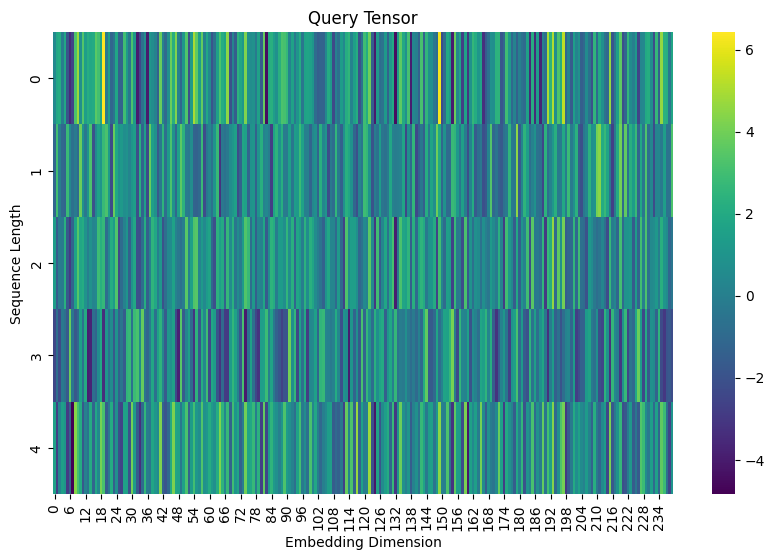

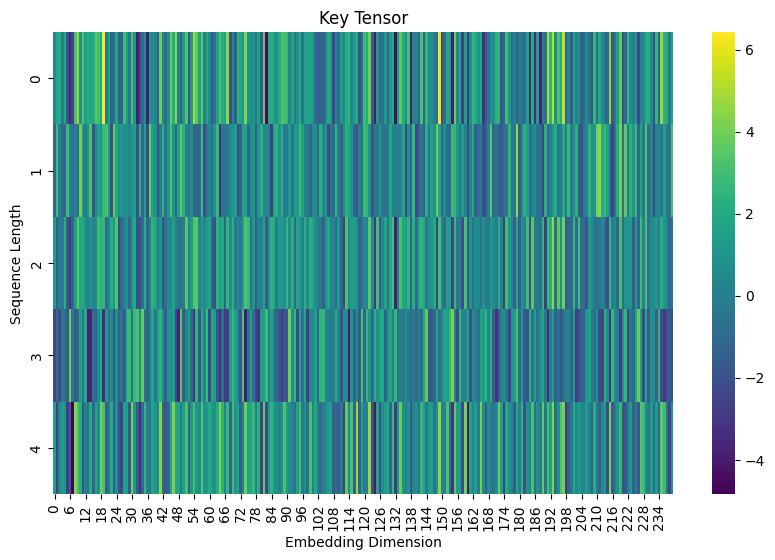

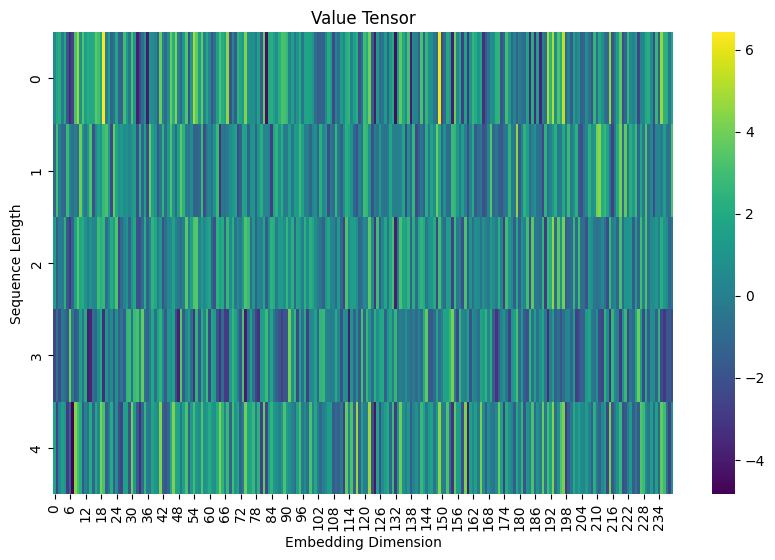

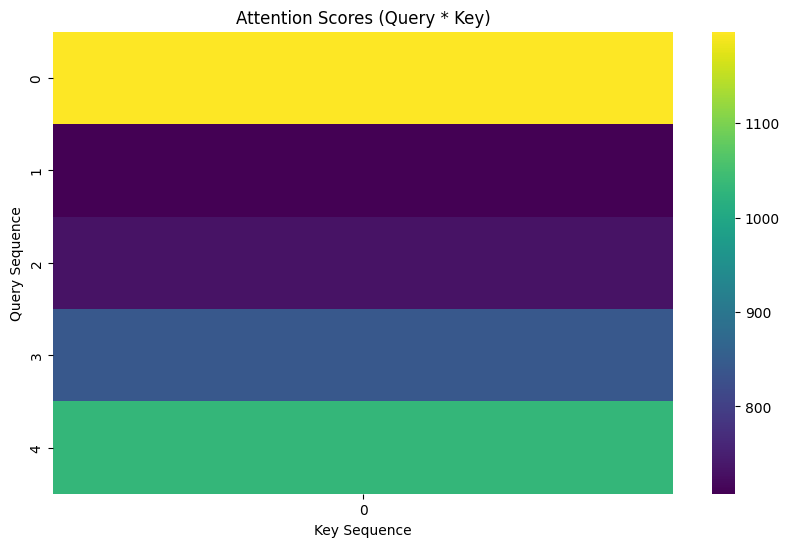

In [103]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# モデルのロード (既にロード済みであればスキップ可能)
model_path = model_dir_path.joinpath(version + 'translation_transfomer.pth')
loaded_model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    embedding_size=embedding_size,
    vocab_size_src=vocab_size_src, vocab_size_tgt=vocab_size_tgt,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
).to(device)
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.eval()

# QKVテンソルを取得するためのフック関数を定義
qkv_activations = {'query': None, 'key': None, 'value': None}

def get_qkv_hook(name):
    def hook(module, input, output):
        # エンコーダ層のQ, K, Vテンソルを取得
        qkv_activations['query'], qkv_activations['key'], qkv_activations['value'] = input
    return hook

# Transformerの最初のエンコーダ層にフックを設定
for name, layer in loaded_model.transformer_encoder.named_modules():
    if isinstance(layer, nn.MultiheadAttention):
        layer.register_forward_hook(get_qkv_hook(name))

# テスト用の入力データを準備
text = '9+4'
tokens = convert_text_to_indexes(text, vocab=vocab_src)
num_tokens = len(tokens)

# Tensorに変換
src = torch.LongTensor(tokens).reshape(num_tokens, 1).to(device)
mask_src = torch.zeros((num_tokens, num_tokens), device=device).type(torch.bool)

# エンコーダに入力してQKVを取得
with torch.no_grad():
    memory = loaded_model.encode(src, mask_src)

# 取得されたQ, K, Vを可視化する
def plot_qkv_tensors(tensor, title):
    tensor = tensor.squeeze(1).cpu().numpy()  # [seq_len, embedding_size] に変換
    plt.figure(figsize=(10, 6))
    sns.heatmap(tensor, cmap='viridis', annot=False)
    plt.title(title)
    plt.xlabel('Embedding Dimension')
    plt.ylabel('Sequence Length')
    plt.show()

# Query, Key, Valueのテンソルを可視化
plot_qkv_tensors(qkv_activations['query'], 'Query Tensor')
plot_qkv_tensors(qkv_activations['key'], 'Key Tensor')
plot_qkv_tensors(qkv_activations['value'], 'Value Tensor')

# QueryとKeyの内積からAttention Scoreを計算
def calculate_attention_scores(query, key):
    # queryとkeyの内積を取ることで、スコアを計算
    scores = torch.matmul(query, key.transpose(-2, -1))  # [seq_len, seq_len]
    scores = scores.squeeze(1).cpu().numpy()  # CPUに戻してnumpyに変換
    return scores

attention_scores = calculate_attention_scores(qkv_activations['query'], qkv_activations['key'])

# Attention Scoreの可視化
plt.figure(figsize=(10, 6))
sns.heatmap(attention_scores, cmap='viridis', annot=False)
plt.title('Attention Scores (Query * Key)')
plt.xlabel('Key Sequence')
plt.ylabel('Query Sequence')
plt.show()
